# Zombie Attack Simulation using mempool historical data

In [20]:
# Data taken from https://jochen-hoenicke.de/queue/#BTC,all,count

import json 
import os.path
import math
import matplotlib.pyplot as plt
import numpy as np

PROBLEMATIC_INTERVALS = [[1516728783, 1516729440], [1515943500, 1515944160]] # problematic intervals that should not be considerated (probably the BTC nodes of the owner went offline for a while)

# if highest_priority == True, then txs are put in the first positions of the queue (used when we are considering a fee level that is greater than the maximum fee level in our dataset: in this case, we
# want that our transactions are those with the highest priority in the mempool)
def simulate(mempool_data, fee_index_in_ranges, num_zombie_channels, highest_priority=False, dynamic=False, alpha=0.5, beta=1, step=1):
    
    blocksCounter = 0
    last_total_tx_count = None

    initial_tx_with_same_fee = 0
    
    if not highest_priority:
        initial_tx_with_same_fee = mempool_data[0][1][fee_index_in_ranges]

    for snapshot in mempool_data:
        timestamp = snapshot[0]
        tx_count_per_fee_level = snapshot[1]
        
        total_tx_count = sum(tx_count_per_fee_level)

        if last_total_tx_count is None:
            last_total_tx_count = total_tx_count
        else:
            is_in_problematic_interval = False

            for interval in PROBLEMATIC_INTERVALS:
                if(timestamp >= interval[0] and timestamp < interval[1]):
                    is_in_problematic_interval = True
                    break

            if total_tx_count < last_total_tx_count and not is_in_problematic_interval:
                
                # New Block?
                blocksCounter += 1
                
                estimated_num_tx_in_block = last_total_tx_count - total_tx_count

                # TODO: should we consider that each block contains the max number of transactions or historical data, to decide how many closing channel transactions
                # are included in this block?

                tx_with_higher_fee = 0 # Number of transactions that have an higher fee than the closing channel transactions
                
                index = fee_index_in_ranges + 1

                while index < len(tx_count_per_fee_level):
                    tx_with_higher_fee = tx_with_higher_fee + tx_count_per_fee_level[index]
                    index = index + 1

                if(tx_with_higher_fee <= estimated_num_tx_in_block): # if the new block can contain transactions with the level of fee we are considering for closing channel transactions
                    
                    # 2 ways: random ordering of all the tx with this fee level or ordered queue based on arrival time

                    number_of_confirmed_tx = estimated_num_tx_in_block - tx_with_higher_fee # ... of the same fee rate of the closing channel transactions

                    if(initial_tx_with_same_fee >= number_of_confirmed_tx):

                        initial_tx_with_same_fee -= number_of_confirmed_tx

                    else:
                        if(initial_tx_with_same_fee > 0):
                            number_of_confirmed_tx -= initial_tx_with_same_fee
                            initial_tx_with_same_fee = 0

                        num_zombie_channels -= number_of_confirmed_tx    


                    if(num_zombie_channels <= 0):
                        return blocksCounter

                if(dynamic and blocksCounter % step == 0):
                    alpha = alpha * beta
                    fee_index_in_ranges = math.floor(alpha * (len(fee_ranges) - 1))

                    if(fee_index_in_ranges >= len(fee_ranges) - 1):
                        fee_index_in_ranges = len(fee_ranges) - 1
                    
        last_total_tx_count = total_tx_count
    
    return None


# Mempool Data preprocessing to JSON array 

In [3]:

INITIAL_NUM_ZOMBIE_CHANNELS = 60000
LN_CLOSING_CHANNEL_DELAY = 1000 # ~ 1 week

accumulated_txs = 0 # transactions that would have been already confirmed without the zombie channels transactions

# We read the file containing mempool historical data

i = 1
mempool_data_json_string = ''

while os.path.exists(f"mempool/{i}_mempool"):
    mempool_data_file = open(f"mempool/{i}_mempool", mode = 'r')
    mempool_data_content = mempool_data_file.read()
    
    # We replace call() from file content (it is used for the website to load the JSONP)
    mempool_data_content = mempool_data_content[5 : len(mempool_data_content) - 2]
    
    # I remove the first and the last square brackets, then I will add them again at the end before parsing the JSON,
    # in order to obtain a single merged json of all the mempool data
    mempool_data_content = mempool_data_content[1:]
    mempool_data_content = mempool_data_content[:-1]

    mempool_data_content += ','

    mempool_data_json_string += mempool_data_content
    mempool_data_file.close()

    i += 1

mempool_data_json_string = mempool_data_json_string[:-1]
mempool_data_json_string = f"[{mempool_data_json_string}]"

# Parsing JSON file

mempool_data = json.loads(mempool_data_json_string) 

# STATIC CASE

# Blocks needed to close all channels with average and median fee

In [4]:
fee_ranges = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]

initial_timestamp = mempool_data[0][0]
initial_tx_count_per_fee_level = mempool_data[0][1]
    
total_tx_count = sum(initial_tx_count_per_fee_level)

acc = 0
i = 0
median_index = 0

# Computing the index of the median fee
for c in initial_tx_count_per_fee_level:
    acc = acc + c
    if acc >= total_tx_count/2:
        median_index = i
        break
    else:
        i = i + 1    

acc = 0
i = 0

# Computing the average fee
for c in initial_tx_count_per_fee_level:
    acc = acc + (fee_ranges[i] * c)
    i = i + 1

avg_fee = acc/total_tx_count

average_index = 0

i = 1

# Computing the index of the average fee
while i < len(fee_ranges):
    if fee_ranges[i-1] <= avg_fee and avg_fee <= fee_ranges[i]:
        average_index = i
        break
    i = i + 1

blocks_to_close_all_channels_with_median_fee = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, median_index, INITIAL_NUM_ZOMBIE_CHANNELS)
blocks_to_close_all_channels_with_avg_fee = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, average_index, INITIAL_NUM_ZOMBIE_CHANNELS)

print(blocks_to_close_all_channels_with_median_fee, "blocks to close all channels with median fee ( =", fee_ranges[median_index], ")")
print(blocks_to_close_all_channels_with_avg_fee, "blocks to close all channels with average fee ( =", fee_ranges[average_index], ")")


9315 blocks to close all channels with median fee ( = 2 )
9005 blocks to close all channels with average fee ( = 6 )


# Simulation considering all the fee levels supported by the dataset (blocks needed to close all channels as a function of the fee chosen for the closing channels transactions)

12883 blocks to close all channels with fee = 0
9933 blocks to close all channels with fee = 1
9315 blocks to close all channels with fee = 2
9214 blocks to close all channels with fee = 3
9148 blocks to close all channels with fee = 4
9052 blocks to close all channels with fee = 5
9005 blocks to close all channels with fee = 6
8985 blocks to close all channels with fee = 7
8885 blocks to close all channels with fee = 8
8711 blocks to close all channels with fee = 10
8621 blocks to close all channels with fee = 12
8550 blocks to close all channels with fee = 14
8506 blocks to close all channels with fee = 17
8341 blocks to close all channels with fee = 20
8306 blocks to close all channels with fee = 25
8174 blocks to close all channels with fee = 30
8054 blocks to close all channels with fee = 40
5075 blocks to close all channels with fee = 50
4873 blocks to close all channels with fee = 60
4783 blocks to close all channels with fee = 70
1644 blocks to close all channels with fee = 80


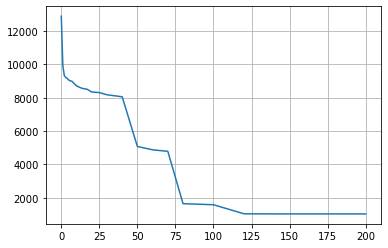

In [5]:
fee_ranges = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200]

fig, ax = plt.subplots()
ax.grid(True)

needed_blocks = [] # number of blocks needed to close all the zombie channels

k = 0

while(k < len(fee_ranges)):
    blocks_to_close_all_channels = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, k, INITIAL_NUM_ZOMBIE_CHANNELS)

    print(blocks_to_close_all_channels, "blocks to close all channels with fee =", fee_ranges[k])

    needed_blocks.append(blocks_to_close_all_channels)
    k += 1

plt.plot(fee_ranges, needed_blocks)
plt.show()    


# Simulation considering an alpha parameter that indicates the aggressiveness of users that are trying to close channels (blocks needed to close all channels as a function of alpha parameter)

12883 blocks to close all channels with alpha = 0.0
12883 blocks to close all channels with alpha = 0.01
12883 blocks to close all channels with alpha = 0.02
12883 blocks to close all channels with alpha = 0.03
9933 blocks to close all channels with alpha = 0.04
9933 blocks to close all channels with alpha = 0.05
9933 blocks to close all channels with alpha = 0.06
9933 blocks to close all channels with alpha = 0.07
9315 blocks to close all channels with alpha = 0.08
9315 blocks to close all channels with alpha = 0.09
9315 blocks to close all channels with alpha = 0.1
9315 blocks to close all channels with alpha = 0.11
9214 blocks to close all channels with alpha = 0.12
9214 blocks to close all channels with alpha = 0.13
9214 blocks to close all channels with alpha = 0.14
9214 blocks to close all channels with alpha = 0.15
9148 blocks to close all channels with alpha = 0.16
9148 blocks to close all channels with alpha = 0.17
9148 blocks to close all channels with alpha = 0.18
9148 block

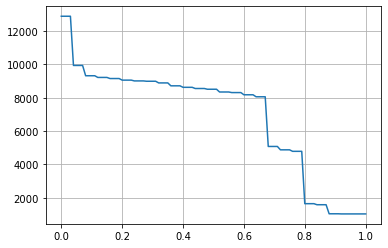

In [6]:
fee_ranges = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200]

fig, ax = plt.subplots()
ax.grid(True)

needed_blocks = []

alphas = np.arange(start=0, stop=1.01, step=0.01)

for alpha in alphas:
    
    fee_index_in_ranges = math.floor(alpha * (len(fee_ranges) - 1))

    if(fee_index_in_ranges >= len(fee_ranges) - 1):
       fee_index_in_ranges = len(fee_ranges) - 1
    
    blocks_to_close_all_channels = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, fee_index_in_ranges, INITIAL_NUM_ZOMBIE_CHANNELS)

    print(blocks_to_close_all_channels, "blocks to close all channels with alpha =", alpha)
    
    needed_blocks.append(blocks_to_close_all_channels)

plt.plot(alphas, needed_blocks)
plt.show() 

# Simulation with a fixed average fee (at the time of arrival of the closing channel transactions): plotting the blocks needed to close all channels as a function of the size of the max-cut (from 60k channels to 1 million channels)

9005 blocks to close all channels with average fee and max-cut size = 60000
9006 blocks to close all channels with average fee and max-cut size = 61000
9007 blocks to close all channels with average fee and max-cut size = 62000
9008 blocks to close all channels with average fee and max-cut size = 63000
9008 blocks to close all channels with average fee and max-cut size = 64000
9009 blocks to close all channels with average fee and max-cut size = 65000
9009 blocks to close all channels with average fee and max-cut size = 66000
9010 blocks to close all channels with average fee and max-cut size = 67000
9012 blocks to close all channels with average fee and max-cut size = 68000
9013 blocks to close all channels with average fee and max-cut size = 69000
9014 blocks to close all channels with average fee and max-cut size = 70000
9016 blocks to close all channels with average fee and max-cut size = 71000
9017 blocks to close all channels with average fee and max-cut size = 72000
9017 blocks 

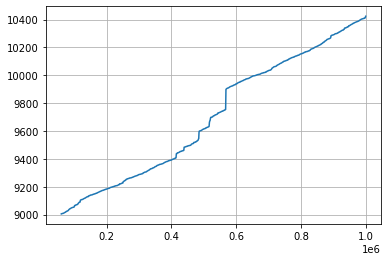

In [7]:
fig, ax = plt.subplots()
ax.grid(True)

fee_ranges = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200, 250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1700, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 10000 ]
needed_blocks = []

tx_count_per_fee_level = mempool_data[0][1]
total_tx_count = sum(tx_count_per_fee_level)

acc = 0
i = 0
for c in tx_count_per_fee_level:
    acc = acc + (fee_ranges[i] * c)
    i = i + 1

avg_fee = round(acc/total_tx_count)

average_index = 0

i = 1

while i < len(fee_ranges):
    if fee_ranges[i-1] <= avg_fee and avg_fee <= fee_ranges[i]:
        average_index = i
        break
    i = i + 1

for zombie_channels in range(60000, 1000000, 1000):
    
    blocks_to_close_all_channels = LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, average_index, zombie_channels)

    print(blocks_to_close_all_channels, "blocks to close all channels with average fee and max-cut size =", zombie_channels)
    
    needed_blocks.append(blocks_to_close_all_channels)

plt.plot(range(60000, 1000000, 1000), needed_blocks)
plt.show() 

# DYNAMIC CASE

# Simulation with a fixed number of initial zombie channels and alpha parameter, blocks needed to close all zombie channels as a function of the factor of growth of the fee (factor of the increase of the fee from the user for each block in which the transaction has not already been confirmed)

alpha = 0 step = 1


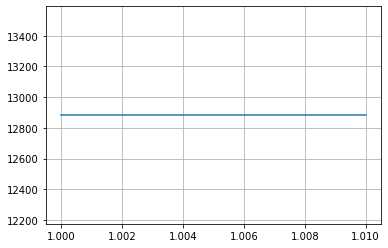

alpha = 0.25 step = 1


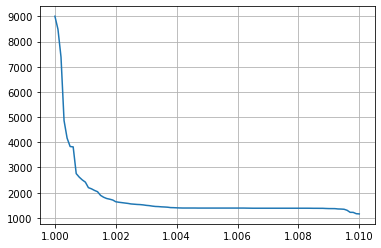

alpha = 0.5 step = 1


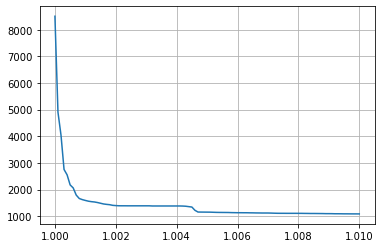

alpha = 0.75 step = 1


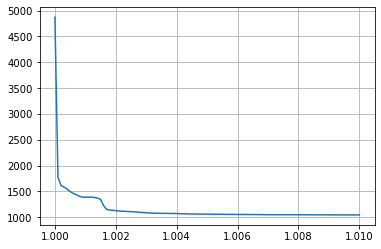

alpha = 1.0 step = 1


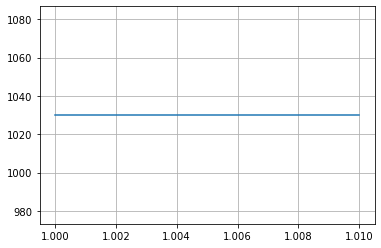

alpha = 0 step = 1


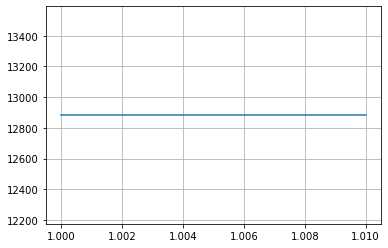

alpha = 0.25 step = 1


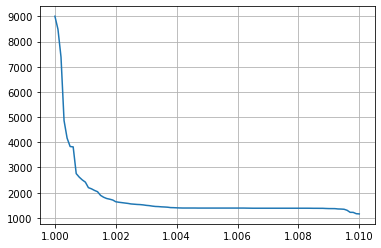

alpha = 0.5 step = 1


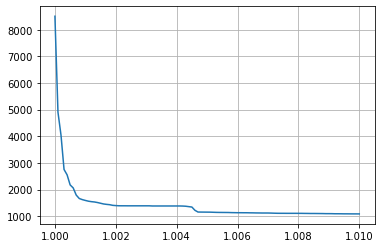

alpha = 0.75 step = 1


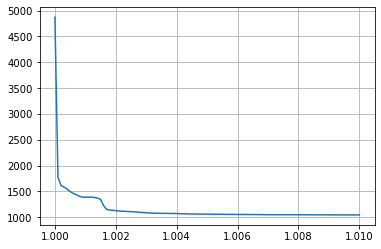

alpha = 1.0 step = 1


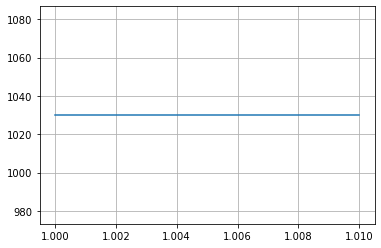

alpha = 0 step = 1


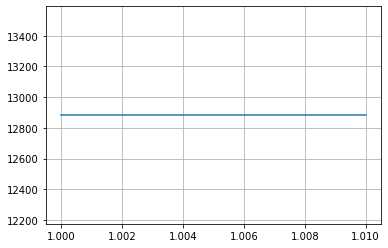

alpha = 0.25 step = 1


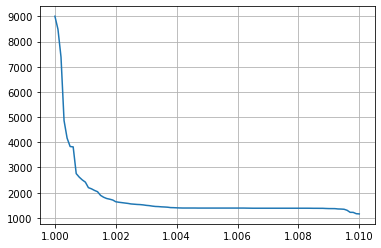

alpha = 0.5 step = 1


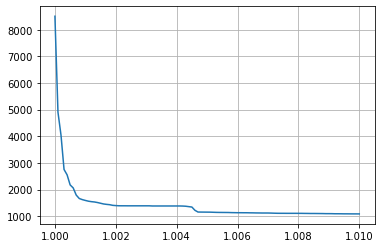

alpha = 0.75 step = 1


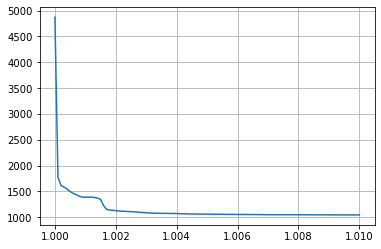

alpha = 1.0 step = 1


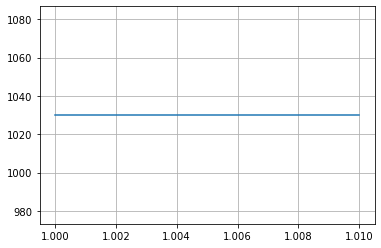

In [22]:
# Dynamic Case
# beta: factor of growth of the fee (new_fee = alpha * beta)
# gamma: percentage of transactions that are replaced
# step: number of blocks after which the fee is increased

fee_ranges = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100, 120, 140, 170, 200]

alphas = [0, 0.25, 0.5, 0.75, 1.0]
betas = np.arange(start=1, stop=1.01, step=0.0001)
step = 1

# Step = 1 block
for alpha in alphas:

    highest_priority = False

    fee_index_in_ranges = math.floor(alpha * (len(fee_ranges) - 1))

    if(fee_index_in_ranges > len(fee_ranges) - 1):
        highest_priority = True
        fee_index_in_ranges = len(fee_ranges) - 1

    needed_blocks = []

    for beta in betas:
        needed_blocks.append(LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, fee_index_in_ranges, INITIAL_NUM_ZOMBIE_CHANNELS, highest_priority=highest_priority, dynamic=True, alpha=alpha, beta=beta, step=step))

    print("alpha =", alpha, "step =", step)

    fig, ax = plt.subplots()
    ax.grid(True)
    plt.plot(betas, needed_blocks) #scatter
    plt.show()  

# Step = 5 blocks
step = 5
for alpha in alphas:

    highest_priority = False

    fee_index_in_ranges = math.floor(alpha * (len(fee_ranges) - 1))

    if(fee_index_in_ranges > len(fee_ranges) - 1):
        highest_priority = True
        fee_index_in_ranges = len(fee_ranges) - 1

    needed_blocks = []

    for beta in betas:
        needed_blocks.append(LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, fee_index_in_ranges, INITIAL_NUM_ZOMBIE_CHANNELS, highest_priority=highest_priority, dynamic=True, alpha=alpha, beta=beta, step=step))

    print("alpha =", alpha, "step =", step)

    fig, ax = plt.subplots()
    ax.grid(True)
    plt.plot(betas, needed_blocks) #scatter
    plt.show() 

# Step = 10 blocks
step = 10
for alpha in alphas:

    highest_priority = False

    fee_index_in_ranges = math.floor(alpha * (len(fee_ranges) - 1))

    if(fee_index_in_ranges > len(fee_ranges) - 1):
        highest_priority = True
        fee_index_in_ranges = len(fee_ranges) - 1

    needed_blocks = []

    for beta in betas:
        needed_blocks.append(LN_CLOSING_CHANNEL_DELAY + simulate(mempool_data, fee_index_in_ranges, INITIAL_NUM_ZOMBIE_CHANNELS, highest_priority=highest_priority, dynamic=True, alpha=alpha, beta=beta, step=step))

    print("alpha =", alpha, "step =", step)

    fig, ax = plt.subplots()
    ax.grid(True)
    plt.plot(betas, needed_blocks) #scatter
    plt.show()    